In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Requirements

In [2]:
!pip install pip --upgrade 
!pip install -U scikit-learn
!pip install mlxtend --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 86.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.4 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlx

## Imports

In [3]:
import time
import joblib

import numpy as np
import pandas as pd
import plotly.express as px 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, StratifiedShuffleSplit

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## Essential functions and preprocessing 

### Metrics, ROC curve, Learning curve

In [4]:
def showMetrics(model, fset, xTrain, yTrain, xTest, yTest):

  print("Train Data on {} features \n".format(fset))  
  print(classification_report(yTrain, model.predict(xTrain)))
  print()
  print("Test Data on {} features \n".format(fset))
  print(classification_report(yTest, model.predict(xTest)))
  
  filename = f"{model.__class__.__name__}_{fset}.joblib"
  joblib.dump(model, filename)

In [5]:
colors = [c[4:] for c in list(mcolors.TABLEAU_COLORS)]

In [6]:
def plotRocCurve(yTest, yPred, nClasses):
  classes = np.arange(nClasses)
  
  yTrue = label_binarize(yTest, classes=classes)
  yScore = label_binarize(yPred, classes=classes)
  
  fpr, tpr, roc_auc = dict(), dict(), dict()

  for i in range(nClasses):
      fpr[i], tpr[i], _ =  roc_curve(yTrue[:, i], yScore[:, i])
      roc_auc[i] =  auc(fpr[i], tpr[i])

  plt.figure()

  for i in range(nClasses):    
    temp_label = 'ROC of class {0} (area={1:0.2f})'.format(i, roc_auc[i])
    plt.plot(fpr[i], tpr[i], label=temp_label, color=colors[i])

    plt.plot([0, 1], [0, 1], linestyle='--', color='black')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
        
  plt.show()

In [7]:
def plotLearningCurve(estimator):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
  
  common_params = {
      "X": xNormal,
      "y": pd.concat([yTrain, yTest]),
      "train_sizes": np.linspace(0.1, 1.0, 5),
      "cv": StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=0),
      "score_type": "both",
      "n_jobs": -1,
      "line_kw": {"marker": "o"},
      "std_display_style": "fill_between",
      "score_name": "Accuracy",
  }

  LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
  handles, label = ax.get_legend_handles_labels()
  ax.legend(handles[:2], ["Training Score", "Test Score"])
  ax.set_title(f"Learning Curve for {estimator.__class__.__name__}")

### Loading data

In [8]:
train = pd.read_csv("/content/drive/MyDrive/MSC/MachineLearning/Project/timeFeaturesTrain.csv")
test = pd.read_csv("/content/drive/MyDrive/MSC/MachineLearning/Project/timeFeaturesTest.csv")
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

xTrain = train.iloc[:, :-1]
yTrain = train.iloc[:, -1]
xTest = test.iloc[:, :-1]
yTest = test.iloc[:, -1]

X = pd.concat([xTrain, xTest])
scaler = StandardScaler()
xNormal = scaler.fit_transform(X)
xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

In [9]:
nClasses = len(np.unique(yTrain))

## Classification

### XGBoost

In [10]:
# new dataset
xgbModel = XGBClassifier(objective="multi:softprob", random_state=42)

init_time = time.time()
xgbModel.fit(xTrain, yTrain)
print("Model calculation time:",  
      (time.time() - init_time)*1000, 
      "miliseconds\n")

showMetrics(xgbModel, "time", xTrain, yTrain, xTest, yTest)

Model calculation time: 142202.07715034485 miliseconds

Train Data on time features 

              precision    recall  f1-score   support

           0       0.79      0.46      0.59       752
           1       0.66      0.60      0.63       810
           2       0.63      0.52      0.57       909
           3       0.57      0.70      0.63      1170
           4       0.81      0.44      0.57       885
           5       0.61      0.71      0.65      1146
           6       0.50      0.73      0.60      1142

    accuracy                           0.61      6814
   macro avg       0.65      0.59      0.60      6814
weighted avg       0.64      0.61      0.61      6814


Test Data on time features 

              precision    recall  f1-score   support

           0       0.14      0.04      0.06       284
           1       0.27      0.27      0.27       223
           2       0.25      0.21      0.23       310
           3       0.21      0.31      0.25       306
           4    

### KNN

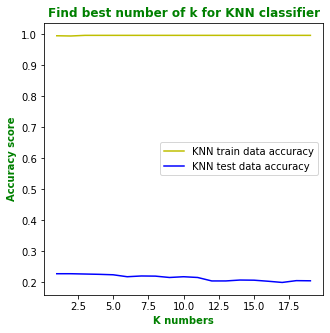

In [25]:
train_knn_accuracy = list()
test_knn_accuracy = list()

for i in range(1, 20):
    temp_KNN = KNeighborsClassifier(n_neighbors=i, weights='distance', metric='manhattan', algorithm='ball_tree')
    temp_KNN.fit(xTrain, yTrain)
    train_knn_accuracy.append(temp_KNN.score(xTrain, yTrain))
    test_knn_accuracy.append(temp_KNN.score(xTest, yTest))
    
plt.figure(figsize = (5, 5)) 
plt.plot([int(i) for i in range(1, 20)], train_knn_accuracy, color="y", label="KNN train data accuracy")
plt.plot([int(i) for i in range(1, 20)], test_knn_accuracy, color="b", label="KNN test data accuracy")

plt.title("Find best number of k for KNN classifier", color = 'green', fontweight = 'bold') 
plt.xlabel("K numbers", color = 'green', fontweight = 'bold') 
plt.ylabel("Accuracy score", color = 'green', fontweight = 'bold')

plt.legend(loc="best")
plt.show()

In [26]:
knn = KNeighborsClassifier(n_neighbors=2, weights='distance', metric='manhattan', algorithm='ball_tree')

init_time = time.time()
knn.fit(xTrain, yTrain)
print("Model calculation time:",  
      (time.time() - init_time)*1000, 
      "miliseconds\n")

showMetrics(knn, "frequency", xTrain, yTrain, xTest, yTest)

Model calculation time: 259.66501235961914 miliseconds

Train Data on frequency features 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       752
           1       1.00      1.00      1.00       810
           2       1.00      1.00      1.00       909
           3       1.00      1.00      1.00      1170
           4       0.97      0.99      0.98       885
           5       0.99      0.98      0.98      1146
           6       1.00      1.00      1.00      1142

    accuracy                           0.99      6814
   macro avg       0.99      1.00      0.99      6814
weighted avg       0.99      0.99      0.99      6814


Test Data on frequency features 

              precision    recall  f1-score   support

           0       0.15      0.12      0.13       284
           1       0.19      0.19      0.19       223
           2       0.25      0.21      0.22       310
           3       0.22      0.29      0.25       306
      

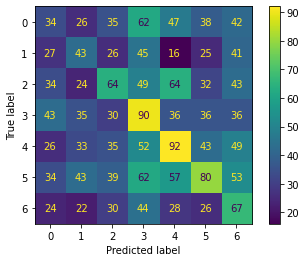

In [27]:
preds = knn.predict(xTest).round()
cm = confusion_matrix(yTest, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

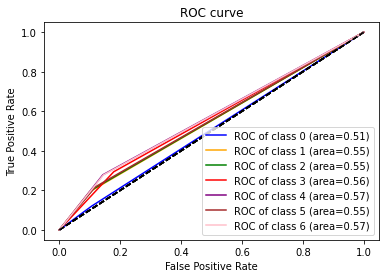

In [28]:
plotRocCurve(yTest, knn.predict(xTest), nClasses)

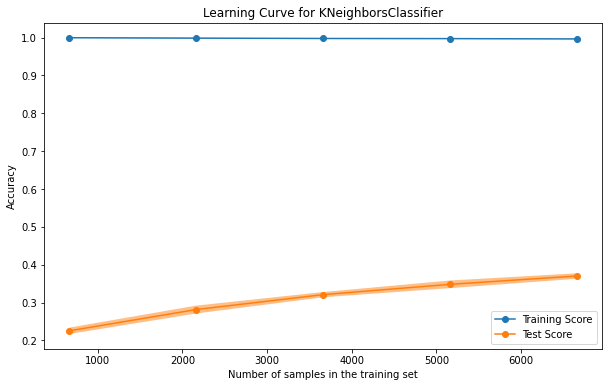

In [29]:
plotLearningCurve(knn)

### Logistic Regression

In [11]:
# new dataset
lr = LogisticRegression()

init_time = time.time()
lr.fit(xTrain, yTrain)
print("Model calculation time:",  
      (time.time() - init_time)*1000, 
      "miliseconds\n")

showMetrics(lr, "time", xTrain, yTrain, xTest, yTest)

Model calculation time: 1714.9949073791504 miliseconds

Train Data on time features 

              precision    recall  f1-score   support

           0       0.35      0.23      0.28       752
           1       0.35      0.34      0.35       810
           2       0.35      0.26      0.30       909
           3       0.30      0.39      0.34      1170
           4       0.31      0.16      0.21       885
           5       0.38      0.43      0.40      1146
           6       0.32      0.45      0.37      1142

    accuracy                           0.34      6814
   macro avg       0.34      0.32      0.32      6814
weighted avg       0.34      0.34      0.33      6814


Test Data on time features 

              precision    recall  f1-score   support

           0       0.20      0.10      0.14       284
           1       0.14      0.18      0.16       223
           2       0.18      0.12      0.15       310
           3       0.17      0.25      0.20       306
           4    

### Ensemble Learning

In [32]:
# initializing all the model objects with default parameters
model1 = xgbModel
model2 = knn
model3 = lr
# Making the final model using voting classifier
ensModel = VotingClassifier(
    estimators=[('xgb', model1), ('knn', model2), ('lr', model3)], voting='hard')

init_time = time.time()
ensModel.fit(xTrain, yTrain)
print("Model calculation time:",  
      (time.time() - init_time)*1000, 
      "miliseconds\n")

showMetrics(ensModel, "time", xTrain, yTrain, xTest, yTest)

Model calculation time: 126421.71716690063 miliseconds

Train Data on time features 

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       752
           1       0.69      0.81      0.74       810
           2       0.74      0.74      0.74       909
           3       0.73      0.81      0.77      1170
           4       0.94      0.51      0.66       885
           5       0.78      0.73      0.75      1146
           6       0.67      0.77      0.72      1142

    accuracy                           0.74      6814
   macro avg       0.76      0.74      0.74      6814
weighted avg       0.75      0.74      0.74      6814


Test Data on time features 

              precision    recall  f1-score   support

           0       0.19      0.18      0.19       284
           1       0.19      0.32      0.24       223
           2       0.20      0.18      0.19       310
           3       0.20      0.26      0.23       306
           4    